In [9]:
import torch
import numpy as np
from torch import Tensor
import pandas as pd

from labproject.plotting import cm2inch, place_boxplot, place_violin

from matplotlib import rc_file
rc_file("../../matplotlibrc")

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns

from labproject.metrics.MMD import *
from labproject.metrics.sliced_wasserstein import sliced_wasserstein_distance
from labproject.metrics.c2st import *

In [10]:
from pathlib import Path

In [48]:
cxr1 = torch.load('../../data/cxr/encs_real.pt')
cxr2 = torch.load('../../data/cxr/encs_fake_pggan.pt')
cxr3 = torch.load('../../data/cxr/encs_fake_stable_diffusion.pt')
ddm1 = torch.load('../../data/ddm/real_data.pt')
ddm2 = torch.load('../../data/ddm/generated_data.pt')
ddm3 = torch.load('../../data/ddm/gaussian_data.pt')

In [52]:
class Metric:
    def __init__(self, name: str, func: callable, **kwargs):
        self.name = name
        self.func = func
        self.kwargs = kwargs

    def __call__(self, x: Tensor, y: Tensor) -> Tensor:
        return self.func(x, y, **self.kwargs)
    

class DistComp:
    def __init__(self, dataset1: Tensor, dataset2: Tensor, metric: Metric, 
                 n_perms: int = 100, perm_size=1000, descr=""):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.metric = metric
        self.n_perms = n_perms
        self.perm_size = perm_size
        self.descr = descr

        columns = [metric.name]
        self.results_df = pd.DataFrame(np.nan, index=range(self.n_perms), columns=columns)

    def run_experiment(self):
        for i in range(self.n_perms):
            self.results_df.loc[i, self.metric.name] = np.random.normal()
        # for i in range(self.n_perms):
        #     dataset2_perm = self.dataset2[torch.randperm(len(self.dataset2))[:self.perm_size]]
        #     dataset1_perm = self.dataset1[torch.randperm(len(self.dataset1))[:self.perm_size]]
        #     metric = self.metric(dataset1_perm.double, dataset2_perm.double())
        #     if isinstance(metric, torch.Tensor):
        #         metric = metric.numpy()
        #     else:
        #         self.results_df.loc[i, self.metric.name] = metric
    
    def reformat_df(self, data):
        """
        reformat the results_df to work with seaborn plot expectations.
        """
        metric = [column_name for _, row in data.iterrows() for column_name, _ in row.items()]
        split_ind = [i for i, _ in data.iterrows() for _ in range(len(data.columns))]
        distance = [value for _, row in data.iterrows() for _, value in row.items()]

        return pd.DataFrame({"metric": metric, "distance": distance, "split_ind": split_ind})
    
    def __repr__(self):
        return f"{self.__class__.__name__}\nDescription:{self.descr}"

def tiled_ticks(x0, x1, n_major_ticks, n_minor_ticks, offset):
    X = (
        np.tile(
            np.linspace(
                x0 - offset,
                x0 + offset,
                n_minor_ticks,
            ),
            n_major_ticks,
        ).reshape(n_major_ticks, n_minor_ticks)
        + np.linspace(x0, x1, n_major_ticks)[:, None]
    )
    return X
        

In [53]:
datasets = [
    (ddm1, ddm1),
    (ddm1, ddm2),
    (ddm2, ddm2),
    (ddm1, ddm3),
    (ddm2, ddm3),
    (ddm3, ddm3),
    (cxr1, cxr1),
    (cxr1, cxr2),
    (cxr2, cxr2),
    (cxr1, cxr3),
    (cxr2, cxr3),
    (cxr3, cxr3),
]

datasets_list = ["ddm", "cxr"]
comparisons_lists = {"ddm": ["real vs real", "real vs DDM", "DDM vs DDM", "real vs Gaussian", "DDM vs Gaussian", "Gaussian vs Gaussian"], 
                     "cxr": ["real vs real", "real vs PGGAN", "PGGAN vs PGGAN", "real vs Stable Diffusion", "PGGAN vs Stable Diffusion", "Stable Diffusion vs Stable Diffusion"]}

descr_list = ['ddm - real vs real',
              'ddm - real vs DDM',
              'ddm - DDM vs DDM',
              'ddm - real vs Gaussian',
              'ddm - DDM vs Gaussian',
              'ddm - Gaussian vs Gaussian',
              'cxr - real vs real',
              'cxr - real vs PGGAN',
              'cxr - PGGAN vs PGGAN',
              'cxr - real vs Stable Diffusion',
              'cxr - PGGAN vs Stable Diffusion',
              'cxr - Stable Diffusion vs Stable Diffusion']

datasets_dict = {desc: dataset for desc, dataset in zip(descr_list, datasets)}

metrics = [
    Metric('SW', 
           sliced_wasserstein_distance),
    Metric('MMD', 
           mmd_rbf),
    Metric('C2ST', 
           c2st_nn,
           ),
]

n_metrics = len(metrics)
n_modalities = len(datasets_list)

# assuming same number of comparisons per dataset
n_comparisons = len(datasets) // n_modalities

experiments = np.zeros([n_metrics, n_modalities, n_comparisons], dtype=object)

for i, metric in enumerate(metrics):
    for j, dataset_id in enumerate(dataset_list):
           for k, comparison in enumerate(comparisons_lists[dataset_id]):
               # print(i, j, k, metric, dataset_id, comparison)
               descr = f"{dataset_id} - {comparison}"
               dataset =  datasets_dict[descr]
               experiments[i, j, k] = DistComp(dataset[0], dataset[1], metric, n_perms=10, perm_size=100, descr=descr)
               experiments[i, j, k].run_experiment()

In [54]:
def generate_palette(hex_color, n_colors=5, saturation="light"):
    if saturation == "light":
        palette = sns.light_palette(hex_color, n_colors=n_colors, as_cmap=False)
    elif saturation == "dark":
        palette = sns.dark_palette(hex_color, n_colors=n_colors, as_cmap=False)
    return palette

color_dict = {"SW": "#cc241d", "MMD": "#eebd35", "C2ST": "#458588", "FID": "#8ec07c"}

In [55]:
X = tiled_ticks(0, 1, n_major_ticks=2, n_minor_ticks=6, offset=0.15)

In [59]:
experiments

array([[[DistComp
         Description:ddm - real vs real, DistComp
                                         Description:ddm - real vs DDM,
         DistComp
         Description:ddm - DDM vs DDM,
         DistComp
         Description:ddm - real vs Gaussian,
         DistComp
         Description:ddm - DDM vs Gaussian,
         DistComp
         Description:ddm - Gaussian vs Gaussian],
        [DistComp
         Description:cxr - real vs real,
         DistComp
         Description:cxr - real vs PGGAN,
         DistComp
         Description:cxr - PGGAN vs PGGAN,
         DistComp
         Description:cxr - real vs Stable Diffusion,
         DistComp
         Description:cxr - PGGAN vs Stable Diffusion,
         DistComp
         Description:cxr - Stable Diffusion vs Stable Diffusion]],

       [[DistComp
         Description:ddm - real vs real, DistComp
                                         Description:ddm - real vs DDM,
         DistComp
         Description:ddm - DDM vs DDM,
    

findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, san

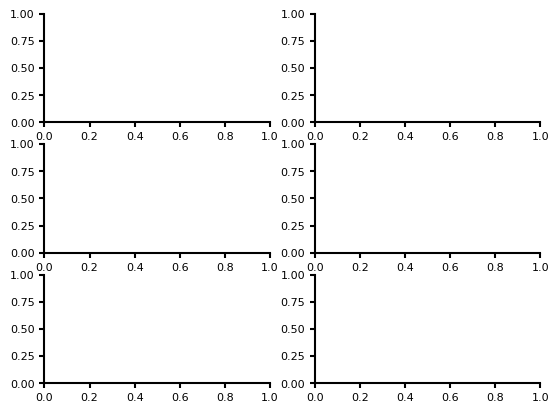

In [58]:
fig, axes = plt.subplots(3, 2)

Metric:  SW
   Experiment: ddm - real vs real


KeyError: 'real vs real'

findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Generic family 'serif' not found because none of the following families were found: Arial, san

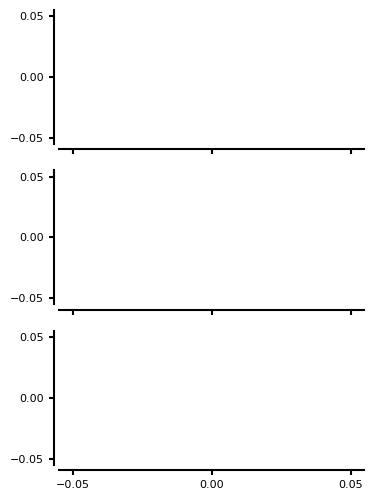

In [21]:
X_space = 0.5
X_order = {"ddm": 0, "cxr": .75}

shade = {}

experiments_reshaped = np.array(experiments).reshape([len(metrics),len(descr_list)])

fig, axes = plt.subplots(len(metrics), 1, figsize=cm2inch((10, 15)), sharex="col")


for ax in axes.flatten():
    # move spines outward
    ax.spines['bottom'].set_position(('outward', 4))
    ax.spines['left'].set_position(('outward', 4))
    ax.locator_params(nbins=3)

for i, ax in enumerate(axes): 
    
    metric_name = metrics[i].name
    metric_experiments = experiments_reshaped[i]
    
    print(f"Metric:  {metric_name}")

    # divide by dataset 
    dataset_key = [e.descr.split("-")[0][:-1] for e in metric_experiments]
    condition_key = [e.descr.split("-")[1][1:] for e in metric_experiments]
    
    body_colors = generate_palette(color_dict[metric_name], n_colors=len(metric_experiments))[2:]
    condition_body_color = {condition: color for condition, color in zip(np.unique(condition_key), body_colors)}
    
    edge_colors = generate_palette(color_dict[metric_name], n_colors=len(metric_experiments), saturation="dark")[:3]
    condition_edge_color = {condition: color for condition, color in zip(np.unique(condition_key), edge_colors)}
        
    spacer = 0

    for j, exp in enumerate(metric_experiments):
        exp_details = exp.descr
        print(f"   Experiment: {exp_details}")
        
        Y = exp.results_df.to_numpy().flatten()        
        X = X_order[dataset_key[j]] + spacer
        spacer += X_space
        place_violin(ax, X, Y, width=0.3, median_color='k', median_bar_length=1, median_lw=1, scatter_radius=5, scatter_face_color="none", whisker_color='k', whisker_lw=1,
                     violin_face_color=condition_body_color[condition_key[j]], violin_edge_color=condition_edge_color[condition_key[j]])

        


    # subplot-level parameters
    ax.set_ylabel(f"{metric_name}\ndistance")

    ax.set_xticks()
    ax.set_xticklabels([0, 1], X_order.keys())